# Исследование объявлений о продаже квартир

Имеются данные сервиса Яндекс.Недвижимость о продаже квартир в Санкт-Петербурге и близлежащих районов. Нужно научиться определять рыночную стоимость объектов недвижимости.

# Описание данных

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [344]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

Используем метод info(), чтобы посмотреть, в каких столбцах присутствуют пропуски.

In [346]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

В первом шаге мы рассмотрели датасет на наличие пропусков. В следующем шаге будем разбираться, какие пропуски можно заполнить, а какие нет.

### Шаг 2. Предобработка данных

Изучим каждый признак, в котором есть пропущенные значения.

`ceiling_height`. К сожалению, исходя из имеющихся данных, я не вижу возможности дать точную оценку высоте потолков. Если бы можно было найти данные из других квартир этого же дома, то можно было заменить медианным значением, но в наших данных такой возможности нет, поэтому оставим пропуски на месте.

`floors_total` Тоже нельзя достоверно определить этаж, поэтому оставим пропуски как они есть.

`living_area` заменим пропуски медианным значением для количества комнат.

In [347]:
living_rooms_median = data.pivot_table(index = 'rooms', values = 'living_area', aggfunc = 'median')
living_rooms_median

,living_area
rooms,
0,18.000
1,17.600
2,30.500
3,45.000
4,63.600
5,91.785
6,123.900
7,145.000
8,161.000


In [348]:
living_rooms_median = data.pivot_table(index = 'rooms', values = 'living_area', aggfunc = 'median')
 
for room in living_rooms_median.index:
    data.loc[data['rooms'] == room,'living_area']=data.loc[data['rooms'] == room,'living_area'].fillna(living_rooms_median.loc[room, 'living_area'])

`is_apartment`
Предположим, что пропуски в данном признаке связаны с тем, что люди, имеющие квартиру, просто не указали, что она не является апартаментом. Ведь если помещение все же является апартаментом, то это один из главных его признаков, забыть указать который - сложно. Поэтому приравняем все пропуски к False.

In [349]:
data.loc[pd.isna(data['is_apartment']), 'is_apartment'] = False

`kitchen_area`
Для того, чтобы восстановить пропуски в этом признаке, введем такой параметр как 'отношение площади кухни к общей площади'.

In [350]:
data['kitchen_to_total'] = data['kitchen_area']/data['total_area']

Посмотрим, какие результаты получились в этом столбце.

In [351]:
data['kitchen_to_total'].describe()

count    21421.000000
mean         0.187355
std          0.072968
min          0.025381
25%          0.133333
50%          0.172414
75%          0.232416
max          0.787879
Name: kitchen_to_total, dtype: float64

Для восстановления пропущенных данных в `kitchen_area` будем умножать `total_area` на медианное значение доли кухни в квартире - 0.172414

In [352]:
med_kitchen = data['kitchen_to_total'].describe()['50%']

In [353]:
data.loc[pd.isna(data['kitchen_area']), 'kitchen_area'] = data[pd.isna(data['kitchen_area'])]['total_area'] * med_kitchen

`balcony`
Предположим, что пропуски в данном признаке связаны с тем, что некоторые клиенты, у которых нет балкона в квартире, просто не указали данный факт, то есть, приравняем все пропуски к 0.

In [354]:
data.loc[pd.isna(data['balcony']), 'balcony'] = 0

`locality_name` Пропуски в данном признаке тоже оставим на месте, так как не вижу вариантов, чтобы можно было точно восстановить название района.

`airports_nearest`,
`cityCenters_nearest`,
`parks_around3000`,
`parks_nearest`,
`ponds_around3000`,
`ponds_nearest`

Я собрал все эти признаки вместе, потому что у них есть общий признак - они описывают местоположение квартиры через отношение к другим объектам. К сожалению, правильно оценить эти признаки без знания точных координат объекта очень тяжело(медианные и прочие значения здесь использовать, на мой взгляд, нельзя, так как даже малейшие отличия с реальным местоположением квартиры может сильно исказить признаки). Возникнуть эти пропуски могли из - за некорректного отображения адреса на карте, возможно по заданному адресу не получилось найти дом на карте, поэтому автоматические данные не были сгенерированны. Пропуски в данных признаках остнутся нетронутыми.

`days_exposition`
Данный признак можно было бы восстановить, если бы мы знали день вывески объявления(что есть) и день закрытия объявления(чего нет). Можно предположить, что пропуски в данном признаке вызваны тем, что объявления, имеющие пропуск в данном признаке, еще не были закрыты на момент получения данной базы данных. Но дата получения неизвестна, поэтому пропуски останутся незаполненными.

Теперь взглянем на признаки, которым надо изменить тип данных.

`floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition`
Все эти данные должны иметь тип данных integer, так как они описывают целочисленные явления. Но, так как во всех признаках, кроме `balcony`, есть пропуски, то можем поменять тип только в `balcony`.

In [355]:
data['balcony'] = data['balcony'].astype('int')

### Вывод

В данном шаге мы убрали пропуски, где это было возможно. Также были изменен тип данных у признаков, которые требовали изменения и не имели пропусков.

### Шаг 3. Посчитайте и добавьте в таблицу

*цену квадратного метра*

In [356]:
data['meter_cost'] = data['last_price']/data['total_area']

*время в формате unix(это потребуется в дальнейшем)*

In [357]:
def time_to_timestamp(date):
    dt = datetime.strptime(date,'%Y-%m-%dT%H:%M:%S')
    return dt.timestamp()

In [358]:
data['tmp'] = data['first_day_exposition'].apply(time_to_timestamp)

*день недели, месяц и год публикации объявления*

In [359]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format=('%Y-%m-%dT%H:%M:%S'))
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

*этаж квартиры; варианты — первый, последний, другой*

In [360]:
def floor(data):
    if data['floor'] == 1:
        return 'Первый'
    elif data['floor'] == data['floors_total']:
        return 'Последний'
    else: return 'Другой'

In [361]:
data['first_or_last_floor'] = data.apply(floor, axis = 1)

In [362]:
data[data['floor'] == data['floors_total']].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,kitchen_to_total,meter_cost,tmp,weekday,month,year,first_or_last_floor
12,10,3890000.0,54.0,2016-06-30,2,NaN,5.0,30.0,5,False,...,NaN,NaN,90.0,0.166667,72037.037037,1.467245e+09,3,6,2016,Последний
13,20,3550000.0,42.8,2017-07-01,2,2.56,5.0,27.0,5,False,...,3.0,298.0,366.0,0.121495,82943.925234,1.498867e+09,5,7,2017,Последний
23,11,2950000.0,32.0,2016-10-29,1,2.60,9.0,17.7,9,False,...,1.0,190.0,615.0,0.190625,92187.500000,1.477699e+09,5,10,2016,Последний
36,13,3790000.0,45.0,2017-01-25,2,NaN,9.0,27.0,9,False,...,0.0,NaN,139.0,0.140000,84222.222222,1.485302e+09,2,1,2017,Последний
43,13,9330000.0,48.0,2017-01-10,2,3.00,4.0,28.0,4,False,...,1.0,492.0,763.0,0.156250,194375.000000,1.484006e+09,1,1,2017,Последний


*соотношение жилой и общей площади, а также отношение площади кухни к общей*

In [363]:
data['living_to_total'] = data['living_area']/data['total_area']

### Вывод

На основании имеющихся признаков мы создали еще несколько, которые в дальнейшем могут сильно помочь понять природу зависимости одних признаков от других.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

*Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.*

Напишем функцию, которая будет выводить характеристики распределения и гистограмму для определенного признака. Также в фунцкию будет параметр bins для гистограмм.

Гистограмма будет выводится на промежутке от Q1-1.5*IQR до Q3+1.5*IQR

In [365]:
def graphics(feature, bins):
    print(data[feature].describe())
    data[feature].hist(bins = bins, range = (data[feature].describe()['25%'] - 1.5 * (data[feature].describe()['75%'] - data[feature].describe()['25%']), data[feature].describe()['75%'] + 1.5*(data[feature].describe()['75%'] - data[feature].describe()['25%'])))

Теперь применим функцию ко всем необходимым признакам.

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


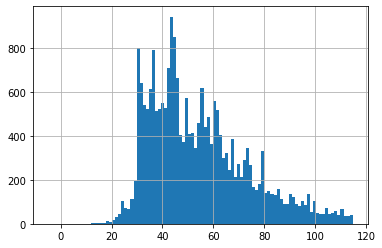

In [366]:
graphics('total_area', 100)

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


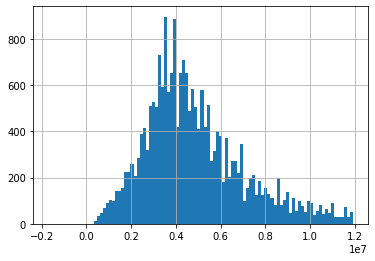

In [367]:
graphics('last_price',100)

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


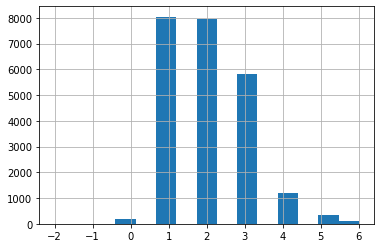

In [368]:
graphics('rooms',15)

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


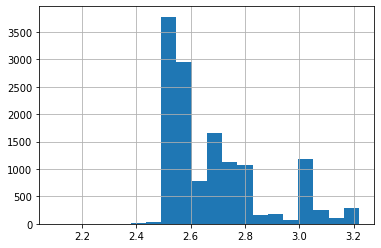

In [369]:
graphics('ceiling_height', 20)

*Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?*

In [370]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее - 180, медиана - 95.

В качестве критерия для оценки обычного времени продажи квартиры вполне может сгодиться медиана - 95 дней.

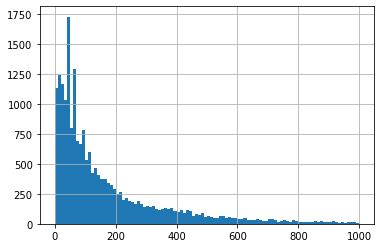

In [371]:
data['days_exposition'].hist(bins=100, range = (0,1000))

Что касается быстрой продажи и необычной долгой, то для того, чтобы оценить это надо построить boxplot.

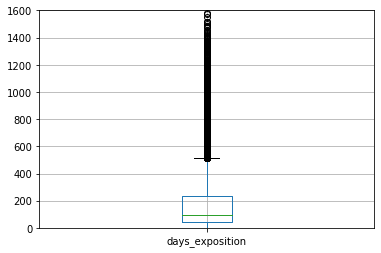

In [372]:
plt.ylim(0,1600)
data.boxplot(column = 'days_exposition')

Я считаю, что можно сказать, что если наблюдение выходит за рамки усов boxplota, то можно сказать, что продажа произошла слишком быстро или необычно долго.

In [373]:
too_fast = data['days_exposition'].describe()['25%'] - (data['days_exposition'].describe()['75%'] - data['days_exposition'].describe()['25%'])
too_slow = data['days_exposition'].describe()['75%'] + (data['days_exposition'].describe()['75%'] - data['days_exposition'].describe()['25%'])

In [374]:
print('Слишком быстрая продажа от', int(too_fast))
print('Слишком медленная продажа от', int(too_slow))

Слишком быстрая продажа от -142
Слишком медленная продажа от 419


Так как нижний хвост ушел в минус, то можно сказать, что очень быстрых продаж нет вообще - даже минимум равный 1 дню входит в boxplot и не является слишком невероятным значением для нашей выборки. В итоге получаем.

In [375]:
print('Слишком быстрых продаж нет.')
print('Слишком медленная продажа от 419 дней.')

Слишком быстрых продаж нет.
Слишком медленная продажа от 419 дней.


*Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.*

Напишем функцию, которая строит boxplot для признака и возвращает верхнюю и нижнюю его границы.

In [376]:
def box_for_feature(feature):
    data.boxplot(column = feature)
    low_border = data[feature].describe()['25%'] - 3 * (data[feature].describe()['75%'] - data[feature].describe()['25%'])
    high_border = data[feature].describe()['75%'] + 3 * (data[feature].describe()['75%'] - data[feature].describe()['25%'])
    return high_border,low_border

Теперь пройдемся по каждому признаку.

`total_images`

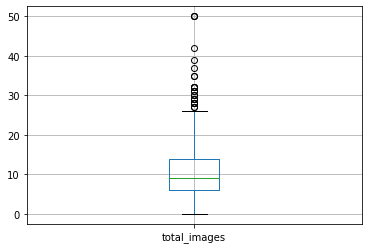

In [377]:
high_border, low_border = box_for_feature('total_images')
data = data.query('(total_images != total_images) or (total_images > @low_border and total_images < @high_border)')

`last_price`

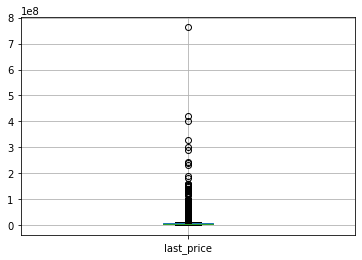

In [378]:
high_border, low_border = box_for_feature('last_price')
data = data.query('(last_price != last_price) or (last_price > @low_border and last_price < @high_border)')

`total_area`

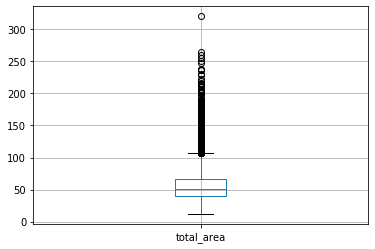

In [379]:
high_border, low_border = box_for_feature('total_area')
data = data.query('(total_area != total_area) or (total_area > @low_border and total_area < @high_border)')

`rooms`

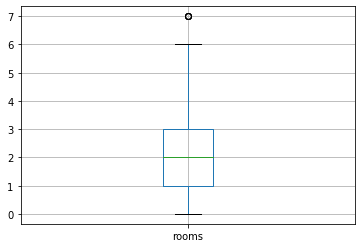

In [380]:
high_border, low_border = box_for_feature('rooms')
data = data.query('(rooms != rooms) or (rooms > @low_border and rooms < @high_border)')

`ceiling_height`

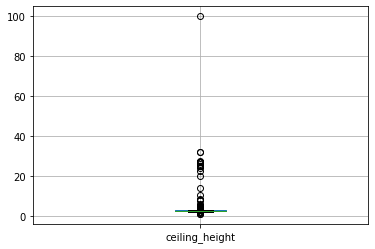

In [381]:
high_border, low_border = box_for_feature('ceiling_height')
data = data.query('(ceiling_height != ceiling_height) or (ceiling_height > @low_border and ceiling_height < @high_border)')

`floors_total`

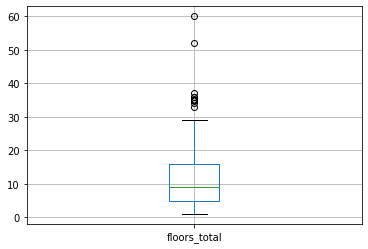

In [382]:
high_border, low_border = box_for_feature('floors_total')
data = data.query('(floors_total != floors_total) or (floors_total > @low_border and floors_total < @high_border)')

`living_area`

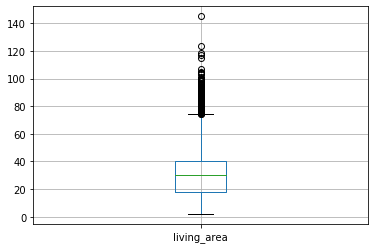

In [383]:
high_border, low_border = box_for_feature('living_area')
data = data.query('(living_area != living_area) or (living_area > @low_border and living_area < @high_border)')

`floor`

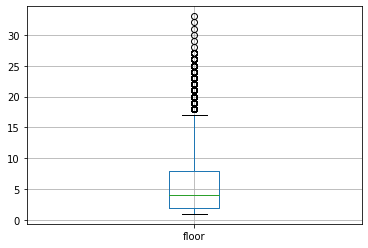

In [384]:
high_border, low_border = box_for_feature('floor')
data = data.query('(floor != floor) or (floor > @low_border and floor < @high_border)')

`kitchen_area`

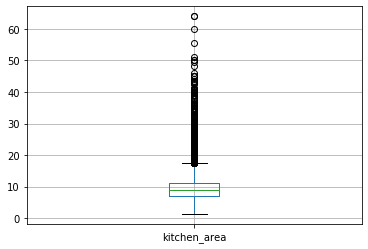

In [385]:
high_border, low_border = box_for_feature('kitchen_area')
data = data.query('(kitchen_area != kitchen_area) or (kitchen_area > @low_border and kitchen_area < @high_border)')

`balcony`

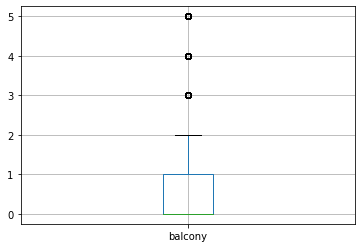

In [386]:
high_border, low_border = box_for_feature('balcony')
data = data.query('(balcony != balcony) or (balcony > @low_border and balcony < @high_border)')

`airports_nearest`

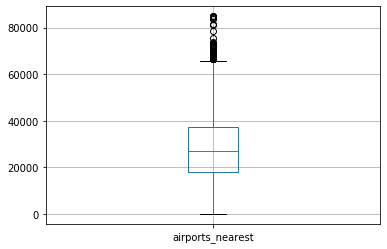

In [387]:
high_border, low_border = box_for_feature('airports_nearest')
data = data.query('(airports_nearest != airports_nearest) or (airports_nearest > @low_border and airports_nearest < @high_border)')

`parks_around3000`

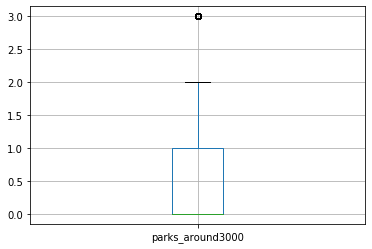

In [388]:
high_border, low_border = box_for_feature('parks_around3000')
data = data.query('(parks_around3000 != parks_around3000) or (parks_around3000 > @low_border and parks_around3000 < @high_border)')

`parks_nearest`

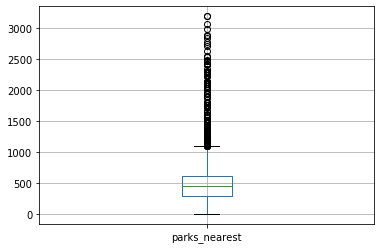

In [389]:
high_border, low_border = box_for_feature('parks_nearest')
data = data.query('(parks_nearest != parks_nearest) or (parks_nearest> @low_border and parks_nearest < @high_border)')

`ponds_around3000`

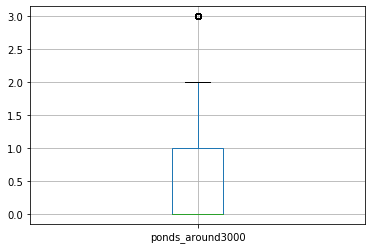

In [390]:
high_border, low_border = box_for_feature('ponds_around3000')
data = data.query('(ponds_around3000 != ponds_around3000) or (ponds_around3000 > @low_border and ponds_around3000 < @high_border)')

`ponds_nearest`

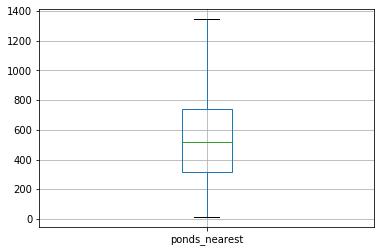

In [391]:
high_border, low_border = box_for_feature('ponds_nearest')
data = data.query('(ponds_nearest != ponds_nearest) or (ponds_nearest > @low_border and ponds_nearest < @high_border)')

In [392]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21498 entries, 1 to 23698
Data columns (total 30 columns):
total_images            21498 non-null int64
last_price              21498 non-null float64
total_area              21498 non-null float64
first_day_exposition    21498 non-null datetime64[ns]
rooms                   21498 non-null int64
ceiling_height          12963 non-null float64
floors_total            21420 non-null float64
living_area             21498 non-null float64
floor                   21498 non-null int64
is_apartment            21498 non-null bool
studio                  21498 non-null bool
open_plan               21498 non-null bool
kitchen_area            21498 non-null float64
balcony                 21498 non-null int64
locality_name           21457 non-null object
airports_nearest        16158 non-null float64
cityCenters_nearest     16174 non-null float64
parks_around3000        16175 non-null float64
parks_nearest           6786 non-null float64
ponds_arou

В итоге, можно увидеть, что после чистки ушло порядка 10% от общего числа данных. С таким объемом можно работать дальше.

*Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.*

Для того, чтобы оценить зависимость стоимости квартиры от различных факторов, будем использовать коэффициент корреляции (кроме этажей, зависимость от этажей будем смотреть через  параметры распределения признаков для каждого этажа(так как это категориальный признак))

In [393]:
data[data['first_or_last_floor'] == 'Первый']['last_price'].describe()

count    2.774000e+03
mean     4.206005e+06
std      2.267185e+06
min      4.300000e+05
25%      2.700000e+06
50%      3.800000e+06
75%      5.197499e+06
max      1.691200e+07
Name: last_price, dtype: float64

In [394]:
data[data['first_or_last_floor'] == 'Другой']['last_price'].describe()

count    1.576600e+04
mean     5.280758e+06
std      2.688406e+06
min      4.500000e+05
25%      3.500000e+06
50%      4.600000e+06
75%      6.350000e+06
max      1.699000e+07
Name: last_price, dtype: float64

In [395]:
data[data['first_or_last_floor'] == 'Последний']['last_price'].describe()

count    2.958000e+03
mean     4.703267e+06
std      2.824943e+06
min      4.300000e+05
25%      2.850000e+06
50%      4.085000e+06
75%      5.800000e+06
max      1.690000e+07
Name: last_price, dtype: float64

Глядя на распределение цены по этим 3 признакам, можно довольно однозначно констатировать, что квартиры на первом этаже - самые дешевые. По всем квантилям и среднему их значения меньше, чем у "последних" и "других" этажей. Если сравнивать "Другие" и "Последние" этажи, то по всем квантилям значение больше у "Других", но среднее и максимальное значение больше у последнего этажа. В итоге можно сделать вывод, что в общем квартиры дороже на "других" этажах, а на первом - самые дешевые. Поэтому есть зависимость между тем, какой этаж и стоимостью квартиры.

Теперь посчитаем коэффициенты корреляции.

In [396]:
print('Коэффициент корреляции между стоимостью квартиры и квадратным метром(площадью) -', data['last_price'].corr(data['total_area']))
print('Коэффициент корреляции между стоимостью квартиры и числом комнат -', data['last_price'].corr(data['rooms']))
print('Коэффициент корреляции между стоимостью квартиры и удаленностью от центра -', data['last_price'].corr(data['cityCenters_nearest']))
print('Коэффициент корреляции между стоимостью квартиры и днем недели, когда было размещено объявление -', data['last_price'].corr(data['weekday']))
print('Коэффициент корреляции между стоимостью квартиры и месяцем, когда было размещено объявление -', data['last_price'].corr(data['month']))
print('Коэффициент корреляции между стоимостью квартиры и годом, когда было размещено объявление - ', data['last_price'].corr(data['year']))

Коэффициент корреляции между стоимостью квартиры и квадратным метром(площадью) - 0.740460855604238
Коэффициент корреляции между стоимостью квартиры и числом комнат - 0.4745261342289291
Коэффициент корреляции между стоимостью квартиры и удаленностью от центра - -0.35850276201552883
Коэффициент корреляции между стоимостью квартиры и днем недели, когда было размещено объявление - -0.014177150357574933
Коэффициент корреляции между стоимостью квартиры и месяцем, когда было размещено объявление - 0.004649537015989207
Коэффициент корреляции между стоимостью квартиры и годом, когда было размещено объявление -  -0.014745050628494067


Также построим графики зависимости цены от данных параметров, чтобы убедится в достоверности полученных коэффициентов.

*Зависимость между стоимостью квартиры и квадратным метром(площадью)*

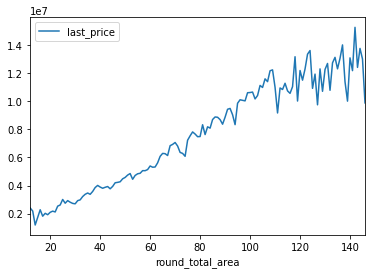

In [397]:
data['round_total_area'] = round(data['total_area'])
data_r_total_area = data.pivot_table(index = 'round_total_area', values = 'last_price')
data_r_total_area.plot()

По графику можно увидеть, что есть зависимость между площадью и ценой.

*Зависимость между стоимостью квартиры и числом комнат*

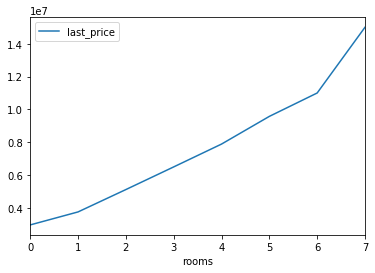

In [398]:
data_rooms= data.pivot_table(index = 'rooms', values = 'last_price')
data_rooms.plot()

По графику можно увидеть, что есть зависимость между ценой и количеством комнат.

*Зависимость между стоимостью квартиры и удаленностью от центра*

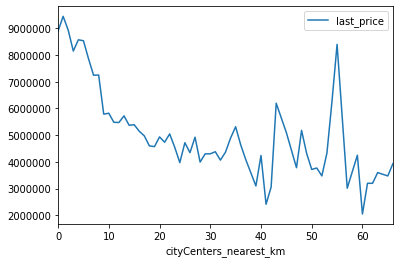

In [399]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000)
data_cityCenters_nearest_km = data.pivot_table(index = 'cityCenters_nearest_km', values = 'last_price')
data_cityCenters_nearest_km.plot()

По данному графику нельзя сказать, что есть строгая зависимость между расстоянием до центра и стоимостью квартиры

*Зависимость между стоимостью квартиры и днем недели, когда было размещено объявление*

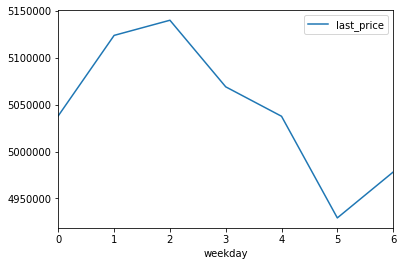

In [400]:
data_weekday = data.pivot_table(index = 'weekday', values = 'last_price')
data_weekday.plot()

По данному графику нельзя сказать, что есть четкая зависимость между днем размещения вакансии и ценой. Можно констатировать, что большинство продаж происходит в среду и меньше всего - в субботу.

*Зависимость между стоимостью квартиры и месяцем, когда было размещено объявление*

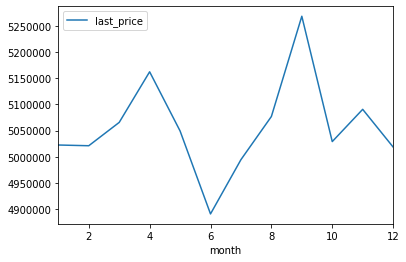

In [401]:
data_month = data.pivot_table(index = 'month', values = 'last_price')
data_month.plot()

По данному графику нельзя сказать, что есть зависимость между месяцем, когда было размещено объявление и стоимостью квартиры.

*Зависимость между стоимостью квартиры и годом, когда было размещено объявление*

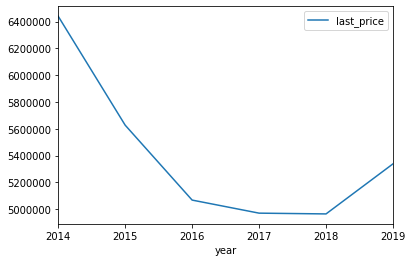

In [402]:
data_year = data.pivot_table(index = 'year', values = 'last_price')
data_year.plot()

На данном графике можно видеть, что самые высокие цены были в 2014 году, которые каждый год шли вниз до 2018 года, а затем пошли вверх, но прямой зависимости здесь нет.

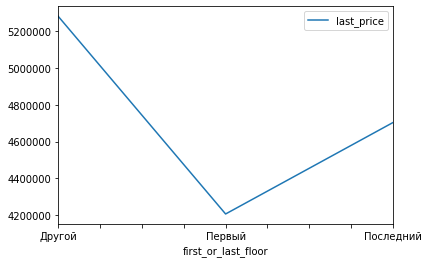

In [403]:
data_floor = data.pivot_table(index = 'first_or_last_floor', values = 'last_price')
data_floor.plot()

На этом графике мы можем лишь увидеть, что квартиры на первом этаже самые дешевые, а на 'других' - самые дорогие.

*Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.*

Выберем 10 населённых пунктов с наибольшим числом объявлений.

In [404]:
top_10_local = data['locality_name'].value_counts().head(10)
top_10_local

Санкт-Петербург      13850
посёлок Мурино         496
посёлок Шушары         428
Всеволожск             377
Пушкин                 337
Колпино                322
посёлок Парголово      312
Гатчина                291
деревня Кудрово        290
Выборг                 225
Name: locality_name, dtype: int64

Теперь отфильтруем таблицу только по этим 10 населенным пунктам.

In [405]:
data_10_locals = data[data['locality_name'].isin(top_10_local.index)]
data_10_locals.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_to_total,meter_cost,tmp,weekday,month,year,first_or_last_floor,living_to_total,round_total_area,cityCenters_nearest_km
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.272277,82920.792079,1.543882e+09,1,12,2018,Первый,0.460396,40.0,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,0.148214,92785.714286,1.440029e+09,3,8,2015,Другой,0.612500,56.0,14.0
6,6,3700000.0,37.3,2017-11-02,1,NaN,26.0,10.6,6,False,...,0.386059,99195.710456,1.509581e+09,3,11,2017,Другой,0.284182,37.0,19.0
7,5,7915000.0,71.6,2019-04-18,2,NaN,24.0,30.5,22,False,...,0.263966,110544.692737,1.555546e+09,3,4,2019,Другой,0.425978,72.0,12.0
9,18,5400000.0,61.0,2017-02-26,3,2.5,9.0,43.6,7,False,...,0.106557,88524.590164,1.488067e+09,6,2,2017,Другой,0.714754,61.0,15.0


In [406]:
data_10_locals.pivot_table(index = 'locality_name',  values = 'meter_cost').sort_values(by = 'meter_cost', ascending = False)

,meter_cost
locality_name,
Санкт-Петербург,107306.628393
Пушкин,101283.295060
деревня Кудрово,92924.998117
посёлок Парголово,90129.345429
посёлок Мурино,85887.848092
посёлок Шушары,78900.457976
Колпино,75208.696486
Гатчина,68641.718283
Всеволожск,66911.503035


Для наглядности построим график завивисмости цены от района.

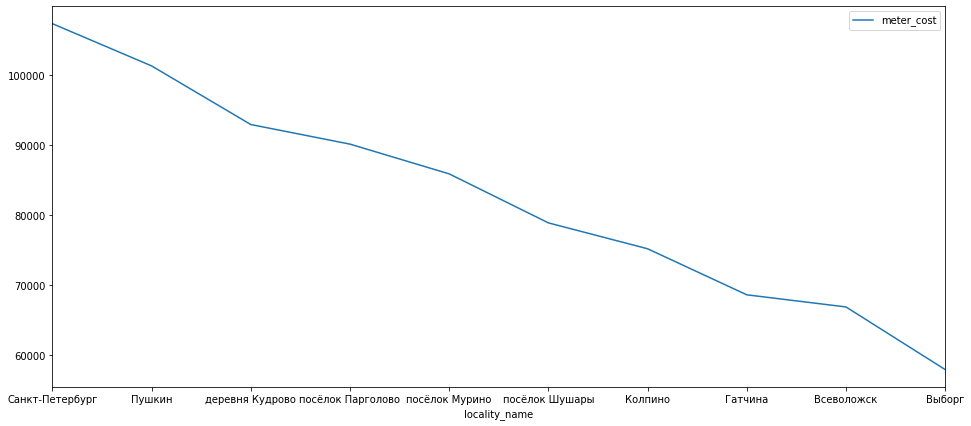

In [407]:
data_10_locals.pivot_table(index = 'locality_name',  values = 'meter_cost').sort_values(by = 'meter_cost', ascending = False).plot(figsize = (16,7))

Из таблицы можем сделать вывод, что самая большая стоимость квадратного метра в Санкт - Петербурге, а самая низкая в Выборге.

*Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.*

Выберем из общей таблицы только те квартиры, которые находятся в Санкт-Петербурге и создадим новый столбец, где расстояние от центра будет выражено в километрах.

In [408]:
data_spb = data[data['locality_name'] == 'Санкт-Петербург']

In [409]:
data_spb['cityCenters_nearest_km'] = round(data_spb['cityCenters_nearest']/1000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Теперь посчитаем среднее значение цены квадратного метра для каждого километра и построим график.

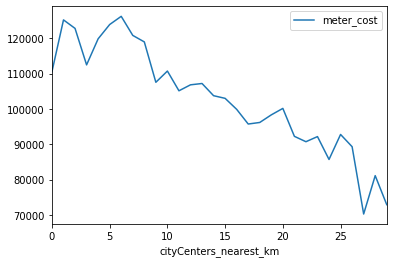

In [410]:
spb_center = data_spb.pivot_table(index = 'cityCenters_nearest_km', values = 'meter_cost')
spb_center.plot()

Судя по графику, сначала резкое, а потом устойчивое падение наблюдается после преодоления отметки в 7 км. Поэтому, сделаю вывод, что центр Санкт-Петербурга находится в радиусе 7 км.

*Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?*

Выделим часть датафрейма, которую мы обозначили как центр Санкт - Петербурга.

In [411]:
data_spb_center = data_spb[data_spb['cityCenters_nearest_km'] <= 7 ]

Посмотрим на распределение признаков площадь, цена, число комнат, высота потолков для центра города и в общем для города.

Площадь

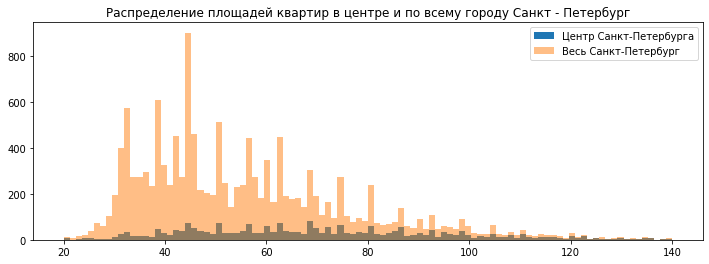

In [412]:
plt.figure(figsize = (12,4))
plt.title('Распределение площадей квартир в центре и по всему городу Санкт - Петербург')
plt.hist(data_spb_center['round_total_area'], range=(20,140), bins = 100, alpha = 1, label = 'Центр Санкт-Петербурга')
plt.hist(data_spb['round_total_area'], range=(20,140), alpha = 0.5, bins = 100, label = 'Весь Санкт-Петербург')
plt.legend(prop={'size':10})

Цена

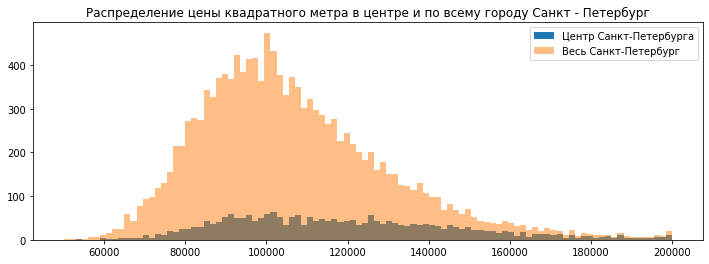

In [413]:
plt.figure(figsize = (12,4))
plt.title('Распределение цены квадратного метра в центре и по всему городу Санкт - Петербург')
plt.hist(data_spb_center['meter_cost'], range=(50000,200000), bins = 100, alpha = 1, label = 'Центр Санкт-Петербурга')
plt.hist(data_spb['meter_cost'], range=(50000,200000), alpha = 0.5, bins = 100, label = 'Весь Санкт-Петербург')
plt.legend(prop={'size':10})

Число комнат

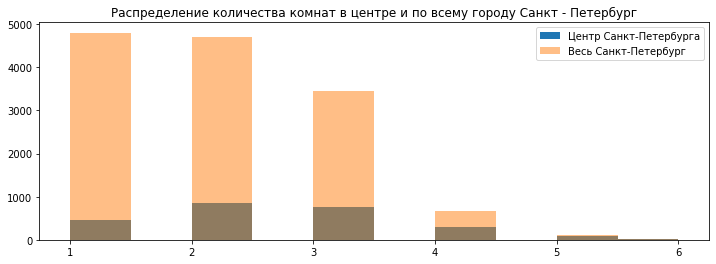

In [414]:
plt.figure(figsize = (12,4))
plt.title('Распределение количества комнат в центре и по всему городу Санкт - Петербург')
plt.hist(data_spb_center['rooms'], range=(1,6), bins = 10, alpha = 1, label = 'Центр Санкт-Петербурга')
plt.hist(data_spb['rooms'], range=(1,6), alpha = 0.5, bins = 10, label = 'Весь Санкт-Петербург')
plt.legend(prop={'size':10})

Высота потолков

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


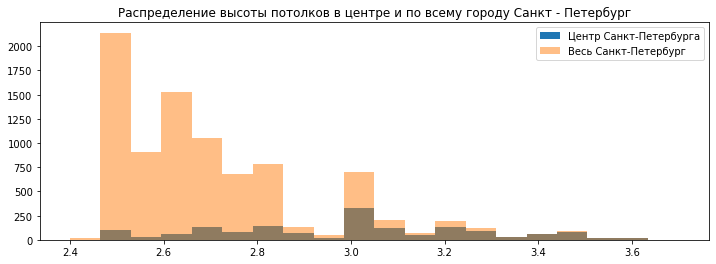

In [415]:
plt.figure(figsize = (12,4))
plt.title('Распределение высоты потолков в центре и по всему городу Санкт - Петербург')
plt.hist(data_spb_center['ceiling_height'], range=(2.4,3.7), bins = 20, alpha = 1, label = 'Центр Санкт-Петербурга')
plt.hist(data_spb['ceiling_height'], range=(2.4,3.7), alpha = 0.5, bins = 20, label = 'Весь Санкт-Петербург')
plt.legend(prop={'size':10})

In [416]:
data_spb_center[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,2496.000000,2.496000e+03,2496.000000,1568.000000
mean,70.689808,8.305398e+06,2.467949,2.992532
std,25.643905,3.075664e+06,1.078750,0.278437
min,12.000000,1.600000e+06,0.000000,2.400000
25%,50.000000,6.000000e+06,2.000000,2.777500
50%,68.075000,7.800000e+06,2.000000,3.000000
75%,87.325000,1.011000e+07,3.000000,3.200000
max,146.100000,1.691307e+07,7.000000,3.600000


In [417]:
data_spb[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,13850.000000,1.385000e+04,13850.000000,8787.000000
mean,56.188820,5.989449e+06,2.012780,2.713006
std,21.342764,2.688015e+06,0.956892,0.229291
min,12.000000,1.190000e+06,0.000000,1.750000
25%,40.200000,4.100000e+06,1.000000,2.530000
50%,51.100000,5.200000e+06,2.000000,2.650000
75%,67.500000,7.100000e+06,3.000000,2.800000
max,146.100000,1.691307e+07,7.000000,3.600000


Площадь квартир в центре явно больше, чем в общем по городу. Средняя и медианная площадь квартир почти на половину больше в центре. 

Что касается цены, то очевидно, что концентрация домов с высокой ценой больше в центре. Средняя цена больше почти на 80 % в центре, медианная - почти на 70%. Квартира с максимальной стоимостью находится в центре.

По количеству комнат можно увидеть, что различия не такие существенные, как у двух предыдущих признаков, но они есть. Среднее значение в центре близко к 3, в общем в городе - к 2. Медианное - 3 и 2 соответсвенно. Можно сделать вывод, что в центре строят более большие квартиры, чем в общем по городу. Квартира с максимальным количеством комнат тоже находится в центре.

Что касается высоты потолков, то и здесь все предсказуемо, в центре они приблизительно 3 метра, в то время как в городе примерно 2.7 метра.

Можно сделать вывод, что в центре строят очень дорогое и комфортное жилье, которое довольно сильно отличается от общегородских квартир по параметрам и цене.

Для того чтобы посмотреть, какие признаки как влияют на стоимость квартир в центре, используем уже знакомый способ - посчитаем коэффициент корреляции.

In [418]:
print('Коэффициент корреляции между стоимостью квартиры и количеством комнат -', data_spb_center['last_price'].corr(data_spb_center['rooms']))
print('Коэффициент корреляции между стоимостью квартиры и этажом -', data_spb_center['last_price'].corr(data_spb_center['floor']))
print('Коэффициент корреляции между стоимостью квартиры и удаленностью от центра -', data_spb_center['last_price'].corr(data_spb_center['cityCenters_nearest']))
print('Коэффициент корреляции между стоимостью квартиры и датой размещения объявления -', data_spb_center['last_price'].corr(data_spb_center['tmp']))

Коэффициент корреляции между стоимостью квартиры и количеством комнат - 0.45896341578936445
Коэффициент корреляции между стоимостью квартиры и этажом - 0.10473545307579116
Коэффициент корреляции между стоимостью квартиры и удаленностью от центра - -0.14635162090181583
Коэффициент корреляции между стоимостью квартиры и датой размещения объявления - -0.0343132455883045


Из получившихся результатов можно сделать вывод, что наибольшее влияние из всех рассматриваемых признаков на цену квартиры оказывает количество комнат, но нельзя сказать, что это влияние очень большое.

Также построим графики зависимости цены от этих признаков для наглядности полученных результатов коэффициентов корреляции.

*Количество комнат*

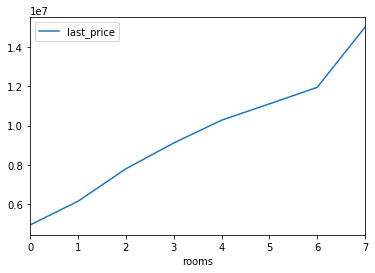

In [419]:
data_spb_center_rooms = data_spb_center.pivot_table(index = 'rooms', values = 'last_price')
data_spb_center_rooms.plot()

Довольно четко видно, что чем больше комнат, тем выше цена квартиры.

*Этаж*

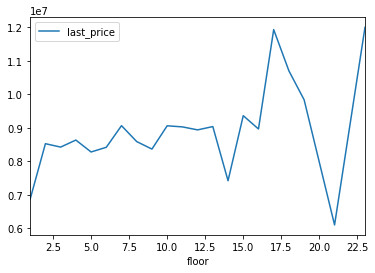

In [420]:
data_spb_center_floor = data_spb_center.pivot_table(index = 'floor', values = 'last_price')
data_spb_center_floor.plot()

Видим провалы на 14 и 21 этажах, видимо из - за того, что во многих домах эти этажи являются последними. В целом, видна общая тенденция, что чем выше этаж, тем больше цена квартиры.

*Удаленность от центра*

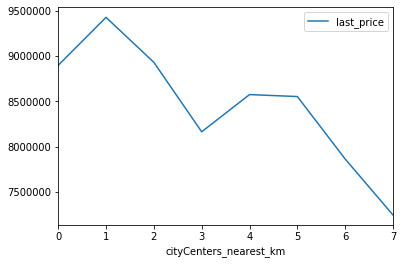

In [421]:
data_spb_center_cityCenters = data_spb_center.pivot_table(index = 'cityCenters_nearest_km', values = 'last_price')
data_spb_center_cityCenters.plot()

На графике в принципе прослеживает не совсем линейная, но зависимость к тому, что чем дальше от центра, тем дешевле квартира.

*Дата размещения объявления*

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


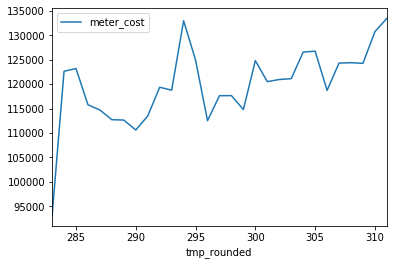

In [422]:
data_spb_center['tmp_rounded'] = round(data_spb_center['tmp']/5000000)
data_spb_center_tmp = data_spb_center.pivot_table(index = 'tmp_rounded', values = 'meter_cost')
data_spb_center_tmp.plot()

На графике можно увидеть, что чем раньше выставлялось объявление, тем за меньшую цену покупалась квартира. Но на данном графике присутствует много всплесков, поэтому тяжело говорить о сильной зависимости данных двух признаков.

### Вывод

В данном шаге мы получили много выводов исходя из имеющихся данных:
1. Выяснили, сколько примерно занимает продажа квартиры - 95 дней
2. Квартиры, на первом и последнем этажах стоят дешевле, чем другие
3. Один из наиболее сильно влияющих на цену квартиры факторов является цена за квадратный метр(довольно логично)
4. Самая высокая стоимость квадратного метра в Санкт-Петербурге, самая низкая - в Выборге(среди топ-10 регионов по количеству объявлений)
5. Определили, какой радиус имеет центр Санкт-Петербурга - 7 км.

### Шаг 5. Общий вывод

В ходе работы над данными Яндекс.Недвижимости был исследован датафрейм с данными об объявлениях о продажах недвижимости. Произведена работа с пропусками, выбивающимися значениями, в результате чего размер датафрейма уменьшился примерно на 10%. Созданы новые признаки на основе первоначальных признаков. На основании этих признаков в дальнейшем были сделаны выводы для различных гипотез:
1. Мы выяснили медианное время продажи квартиры - 95 дней.
2. Из имеющихся признаков больше всего на стоимость квартиры влияет стоимость квадратного метра, площадь, количество комнат(что довольно логично).
3. Больше всего объявлений было для города Санкт - Петербург.
4. На основании цен за квадратный метр было выдвинуто предположение, что центр Санкт-Петербурга составляет область радиусом 7 км.
5. В центре Санкт-Петербурга квартиры более комфортные и дорогие, чем в общем по городу(в среднем большее количество комнат и высота потолков)